# Week 7 Data acqusition from Biosemi

In [1]:
# import require library for preprocess
import mne
import numpy as np
from mne.channels import make_standard_montage
import matplotlib.pyplot as plt
from mne.datasets import eegbci
import scipy
import pickle
import seaborn as sns
from scipy.signal import filtfilt
import pyxdf

# import require library for classification
from sklearn.svm import SVC # SVM library
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA library
from sklearn.neighbors import KNeighborsClassifier # KNN library

from sklearn.metrics import classification_report,confusion_matrix # Result representation
import pandas as pd

## 1 Read recorded data from Biosemi (bdf file)

In [2]:
# ----------- Helper Functions -----------
def load_data(file_path):
    df = pd.read_csv(file_path)
    response = df.get("response.keys")
    if response is not None:
        response = response[1:-2]
        return response.to_numpy()
    return None

def load_bdf(file_path):
    raw = mne.io.read_raw_bdf(file_path, preload=True)
    eegbci.standardize(raw)
    montage = make_standard_montage("biosemi64")
    raw.set_montage(montage, on_missing='ignore')
    raw = raw.resample(128, verbose = False)
    return raw

In [3]:
csv_paths = [
    'psychopy_data_fromlab/csv_label/tailab1.csv',
    # 'psychopy_data_fromlab/csv_label/tailab2.csv',
    # 'psychopy_data_fromlab/csv_label/tailab3.csv',
    # 'psychopy_data_fromlab/csv_label/tailab4.csv',
    # 'psychopy_data_fromlab/csv_label/tailab5.csv'
]
# csv_paths = [
#     'psychopy_data_fromlab/csv_label/tailab1.csv',
# ]

bdf_paths = [
    'databiosemi/s101_b666.bdf',
    # 'databiosemi/s101_b2_1.bdf',
    # 'databiosemi/s101_b3.bdf',
    # 'databiosemi/s101_b4.bdf',
    # 'databiosemi/s101_b5.bdf'
]
# bdf_paths = [
#     'databiosemi/s101_b666.bdf',
# ]

# ----------- Batch Processing -----------
data_responses = [load_data(path) for path in csv_paths]
raw_bios = [load_bdf(path) for path in bdf_paths]

Extracting EDF parameters from c:\Users\Aitthikit\Desktop\bci_code\databiosemi\s101_b666.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 140799  =      0.000 ...   274.998 secs...


In [4]:
raw_bios[0]

<RawEDF | s101_b666.bdf, 73 x 35200 (275.0 s), ~19.7 MiB, data loaded>

**check channel names**

['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'STATUS']
Using matplotlib as 2D backend.


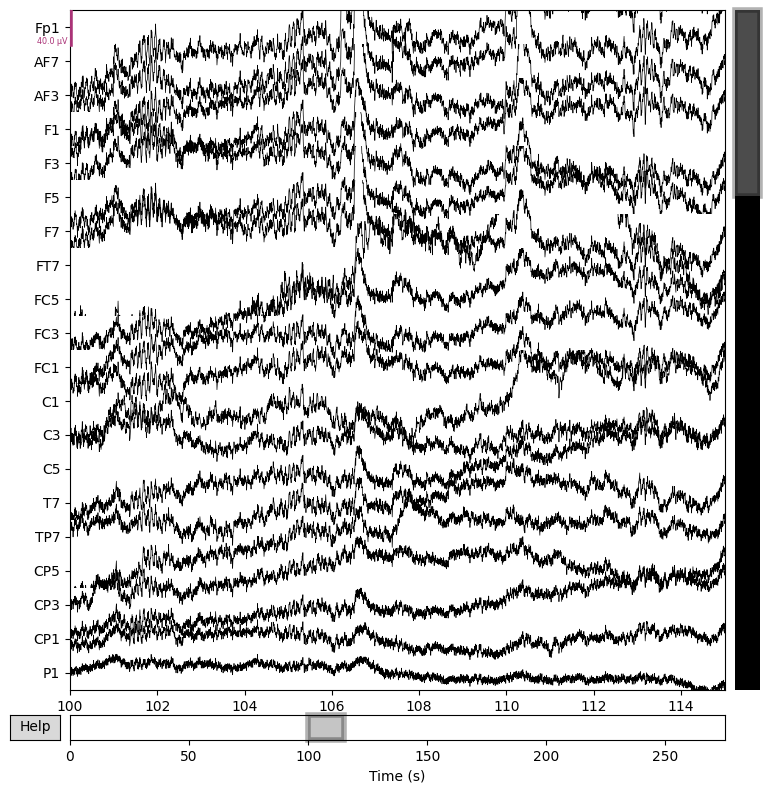

...


In [5]:
for i in raw_bios:
    print(i.ch_names)
    i.plot(start = 100, duration = 15)
    print('...')
   

In [6]:
import mne

# 1. Select only standard 10-20 EEG channels
montage = make_standard_montage("biosemi64")
eeg_chs = [ch for ch in raw_bios[0].ch_names if ch in montage.ch_names]

raw_eegs = []
for raw in raw_bios:
    raw_eeg = raw.copy().pick_channels(eeg_chs)
    raw_eeg.set_montage(montage)
    raw_eegs.append(raw_eeg)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


## 2. Apply filter

ICA

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components


C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_8096\2914352082.py:9: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.3s.


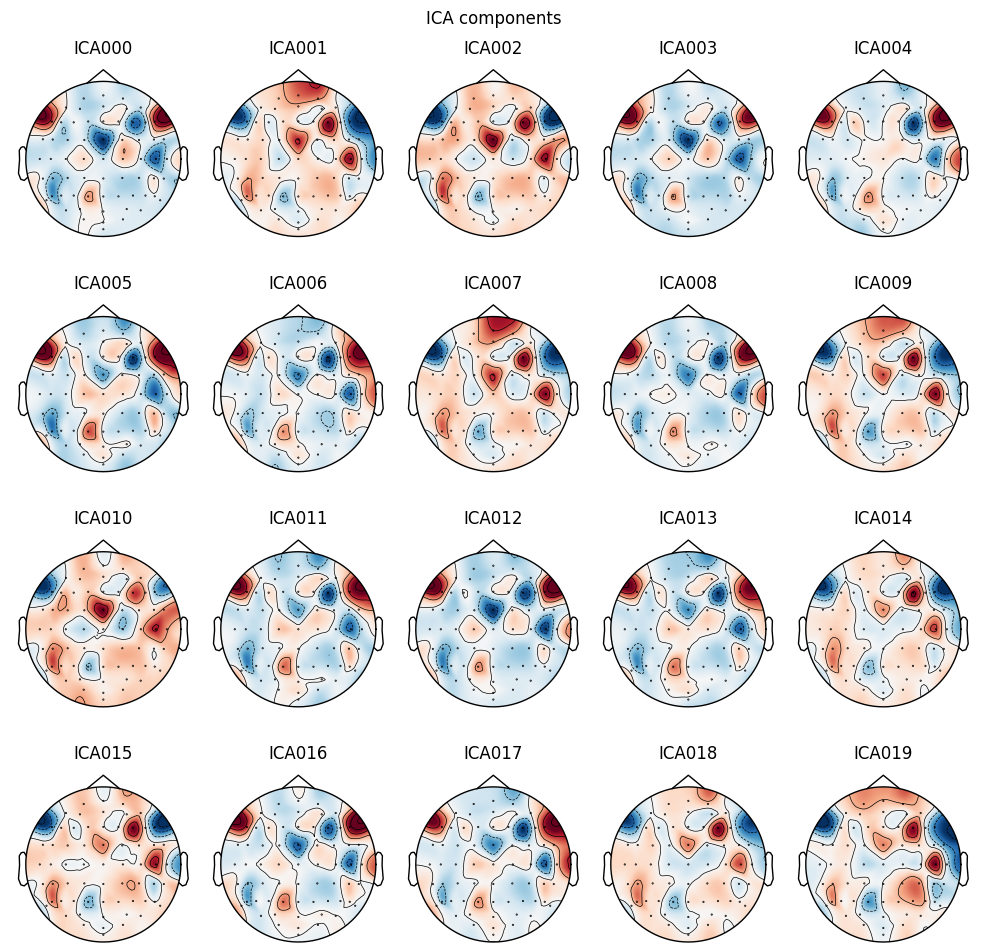

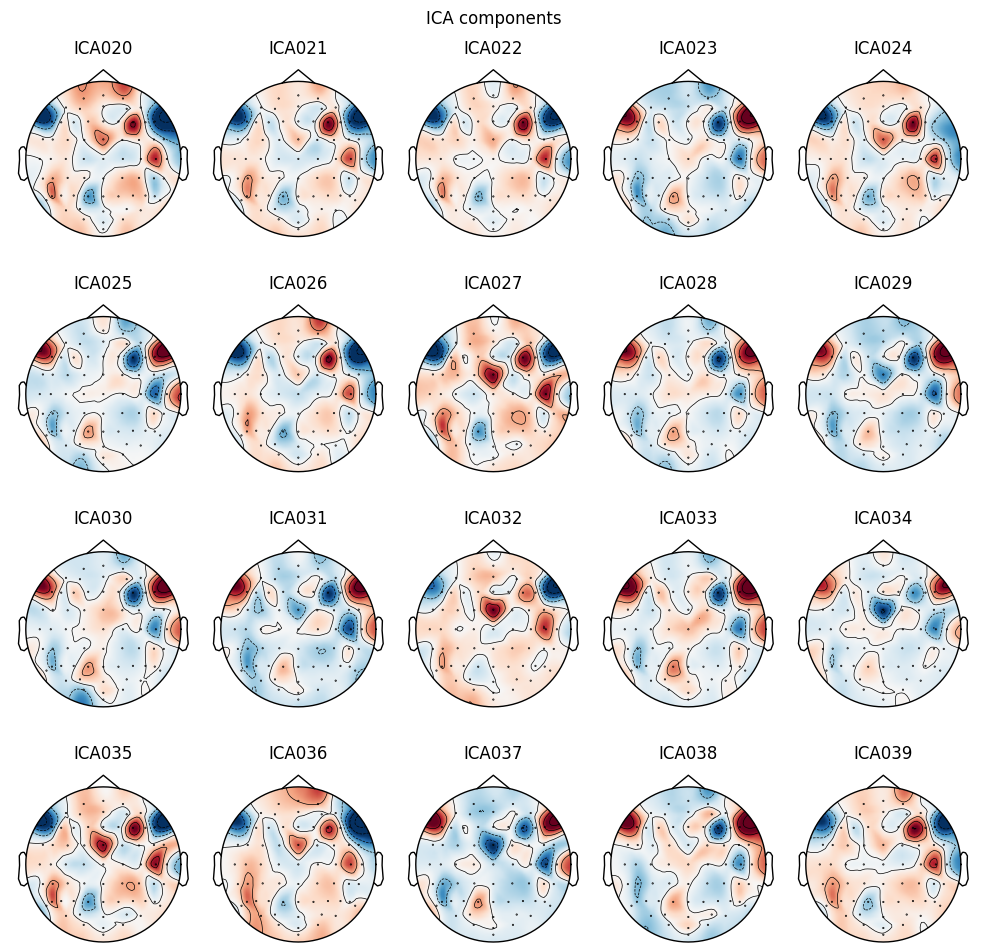

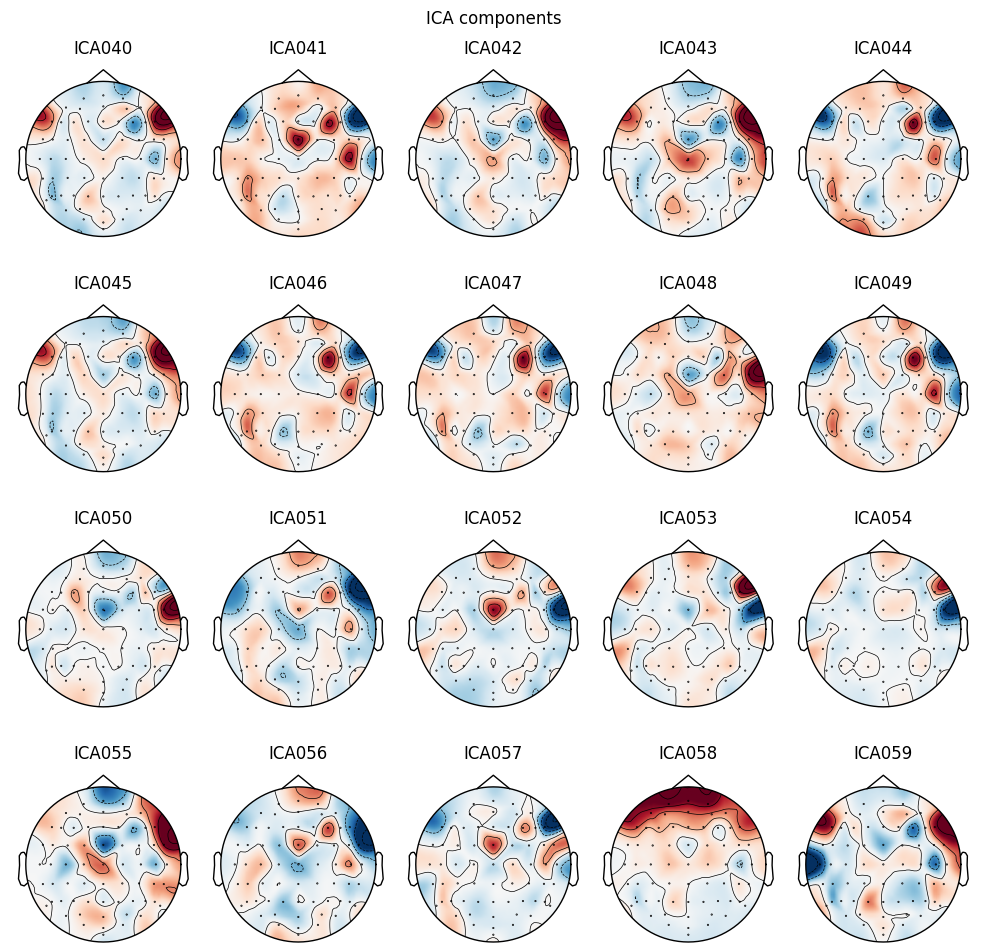

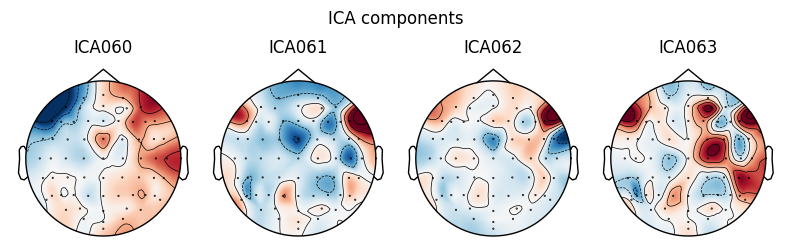

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 780x260.5 with 4 Axes>]

In [7]:
from mne.preprocessing import ICA

# raw.pick_types(eeg=True, exclude='bads')
# raw.set_montage('biosemi64', on_missing='ignore')
# raw.filter(1., 40., fir_design='firwin')
# print(raw.ch_names)
ica = ICA(n_components=64, random_state=97, max_iter='auto')
for raw in raw_eegs:
    ica.fit(raw)
# ica.fit(raw_bio2)
# ica.fit(raw_bio3)
# ica.fit(raw_bio4)
# ica.fit(raw_bio5)
ica.plot_components()

In [8]:
# ica.plot_components()

**raw data PSD plotting**

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


c:\Users\Aitthikit\Desktop\bci_code\.venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


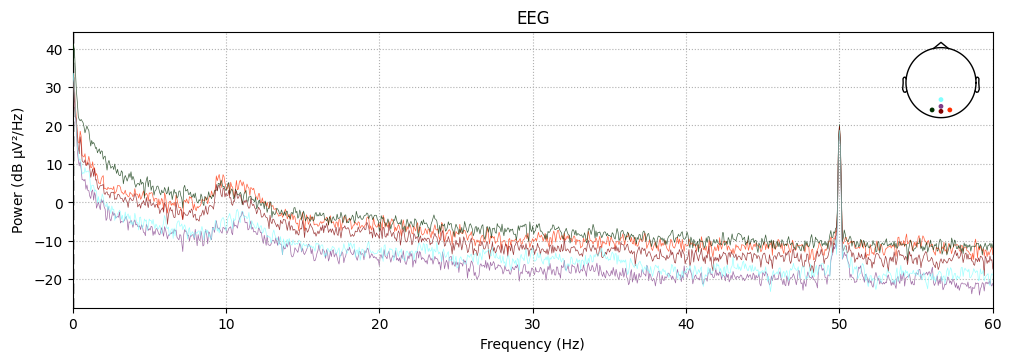

In [9]:
select_channels = ['O1', 'Oz', 'O2', 'Pz', 'POz']
for i in raw_bios:
    i.plot_psd(fmax=60, picks=select_channels)
    plt.show()
# raw_bio.compute_psd(fmax=60).plot(picks=select_channels)
# plt.show()

**apply notch and band-pass filter**

Plotting PSD for batch 1
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


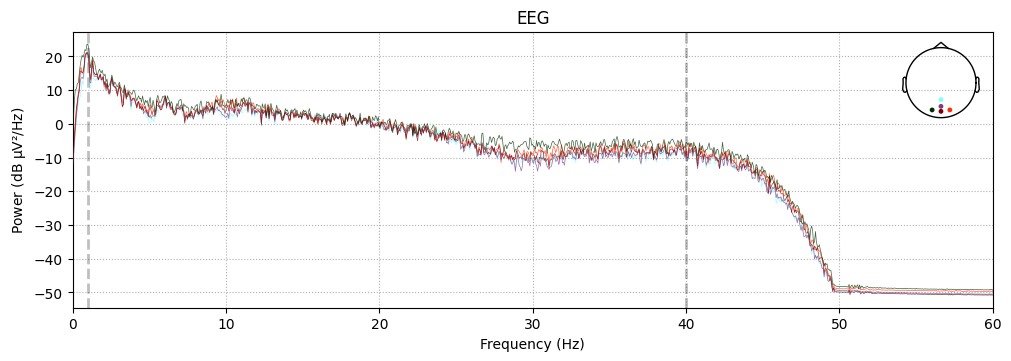

In [10]:
bio_filters = []

for raw in raw_bios:
    raw.set_eeg_reference('average', verbose=False)
    filtered = raw.copy().filter(l_freq=1, h_freq=40, verbose=False)
    filtered = filtered.notch_filter(freqs=50, verbose=False)
    bio_filters.append(filtered)

# Plot Power Spectral Density (PSD) for selected channels
for i, bio in enumerate(bio_filters):
    print(f"Plotting PSD for batch {i+1}")
    bio.compute_psd(fmax=60).plot(picks=select_channels, show=False)

plt.show()
# bio_filter = raw_bio.copy().filter(l_freq=1, h_freq=40) #band-pass function
# bio_filter = bio_filter.copy().notch_filter(freqs=50) #notch filter function
# bio_filter.compute_psd(fmax=60).plot(picks=select_channels)
# plt.show()

In [11]:
# from mne_icalabel import label_components
# ic_labels1 = label_components(raw_bio1, ica, method="iclabel")
# ic_labels2 = label_components(raw_bio2, ica, method="iclabel")
# ic_labels3 = label_components(raw_bio3, ica, method="iclabel")
# ic_labels4 = label_components(raw_bio4, ica, method="iclabel")
# ic_labels5 = label_components(raw_bio5, ica, method="iclabel")
# print(ic_labels1)
# print(ic_labels2)
# print(ic_labels3)
# print(ic_labels4)
# print(ic_labels5)


# 3. Data Epoching

**Biosemi**

In [12]:
print(data_responses[0])

['space' nan nan nan nan nan nan 'space' nan 'space' nan nan nan 'space'
 'space' nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan 'space' nan nan nan nan nan nan nan nan nan 'space' nan
 'space' nan 'space' nan 'space' 'space' nan nan nan nan 'space' nan nan
 nan]


In [13]:
events_all = [mne.find_events(raw, shortest_event=0) for raw in raw_bios]
eventstemp_all = [events.copy() for events in events_all]  # backup copy


Trigger channel STATUS has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
50 events found on stim channel STATUS
Event IDs: [101 102]


In [14]:
# for events, responses_i in zip(events_all, data_responses):
#     for i in range(len(events)):
#         if events[i][2] == 102 and responses_i[i] == 'space':
#             events[i][2] = 102
#         elif events[i][2] == 101 and responses_i[i] == 'space':
#             events[i][2] = 103
#         else:
#             events[i][2] = 101


# #Define what event numbers is
event_dict =  {'101': 101,
'102': 102}

# k = 0
# for events, events_orig in zip(events_all, eventstemp_all):
#     for i in range(len(events)):
#         if events[i][2] != events_orig[i][2]:
#             k += 1
#     print(f"Changed events in batch: {k}")

In [26]:
# Create list of Epochs for each batch
bio_epochs = []
for raw, events in zip(raw_bios, events_all):
    epochs = mne.Epochs(
        raw, events,
        tmin=-0.5,
        tmax=1.0,
        event_id=event_dict,
        preload=True,
        event_repeated='drop',
        baseline=(-0.5, 0.0),
        verbose=True
    )
    bio_epochs.append(epochs)

Not setting metadata
50 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 50 events and 193 original time points ...
0 bad epochs dropped


In [27]:
bio_epochs[0]

<Epochs | 50 events (all good), -0.5 – 1 s (baseline -0.5 – 0 s), ~5.5 MiB, data loaded,
 '101': 40
 '102': 10>

<Epochs | 50 events (all good), -0.5 – 1 s (baseline -0.5 – 0 s), ~5.5 MiB, data loaded,
 '101': 40
 '102': 10>


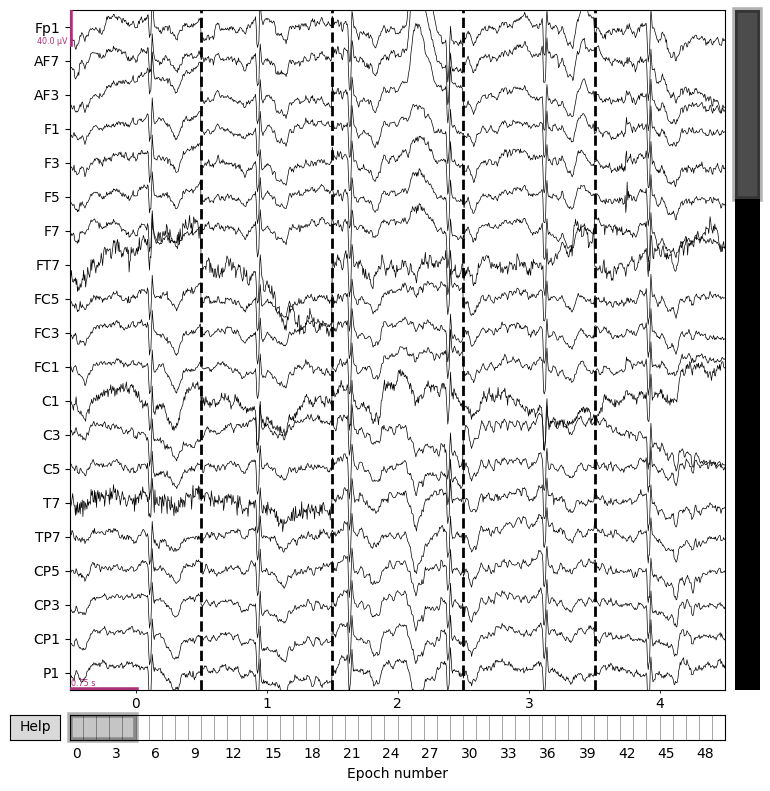

...


In [28]:
for i in bio_epochs:
    print(i)
    i.plot(n_epochs = 5)
    print('...')
# Bio_Epochs.plot(n_epochs = 5)
# print('...')

In [29]:
from mne import combine_evoked
# Create a dictionary to store evoked responses by condition
evoked_by_condition = {
    '102': [],
    '101': []
}

# Loop through each epoch set
for epochs in bio_epochs:
    for condition in evoked_by_condition:
        evoked_by_condition[condition].append(epochs[condition].average())

# Combine evoked responses for each condition
evoked_target = combine_evoked(evoked_by_condition['102'], weights='equal')
evoked_nontarget = combine_evoked(evoked_by_condition['101'], weights='equal')

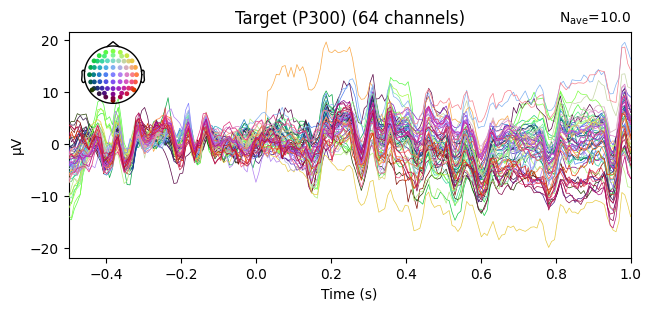

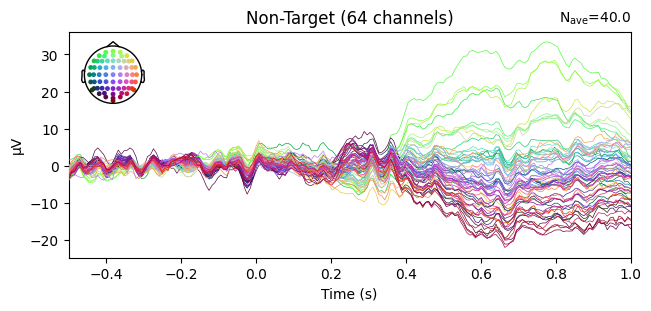

In [30]:
# evoked_target1.plot(spatial_colors=True, titles='Target (P300)')
# # evoked_subtarget.plot(spatial_colors=True, titles='SubTarget (P300)')
# evoked_nontarget1.plot(spatial_colors=True, titles='Non-Target')
# plt.show()
# evoked_target2.plot(spatial_colors=True, titles='Target (P300)')
# # evoked_subtarget.plot(spatial_colors=True, titles='SubTarget (P300)')
# evoked_nontarget2.plot(spatial_colors=True, titles='Non-Target')
# plt.show()
# evoked_target3.plot(spatial_colors=True, titles='Target (P300)')
# # evoked_subtarget.plot(spatial_colors=True, titles='SubTarget (P300)')
# evoked_nontarget3.plot(spatial_colors=True, titles='Non-Target')
# plt.show()
# evoked_target4.plot(spatial_colors=True, titles='Target (P300)')
# # evoked_subtarget.plot(spatial_colors=True, titles='SubTarget (P300)')
# evoked_nontarget4.plot(spatial_colors=True, titles='Non-Target')
# plt.show()
# evoked_target5.plot(spatial_colors=True, titles='Target (P300)')
# # evoked_subtarget.plot(spatial_colors=True, titles='SubTarget (P300)')
# evoked_nontarget5.plot(spatial_colors=True, titles='Non-Target')
# plt.show()
biosemi64_channels = [
    'Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1',
    'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7',
    'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2',
    'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4',
    'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2',
    'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2'
]

evoked_target.plot(spatial_colors=True, titles='Target (P300)',picks=biosemi64_channels)
evoked_nontarget.plot(spatial_colors=True, titles='Non-Target',picks=biosemi64_channels)
plt.show()

combining channels using "mean"
combining channels using "mean"


C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_8096\3808634342.py:1: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(


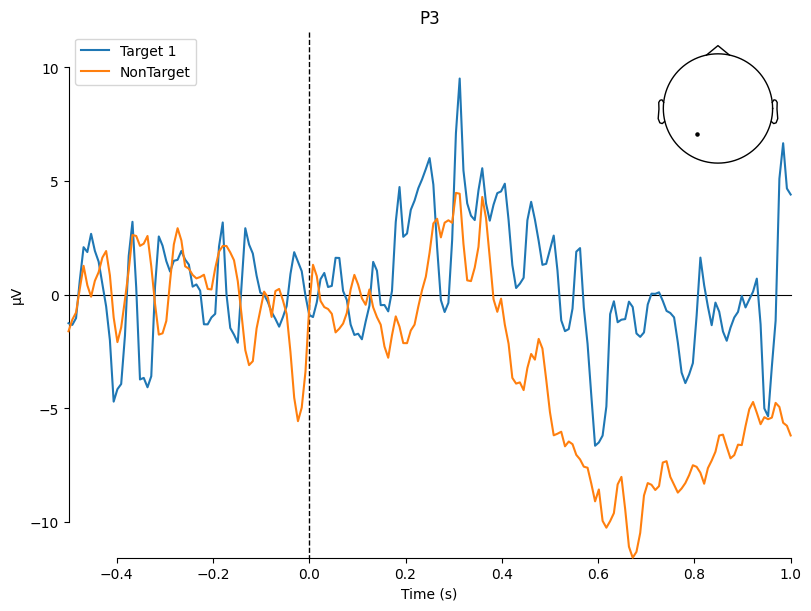

combining channels using "mean"
combining channels using "mean"


C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_8096\3808634342.py:11: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(


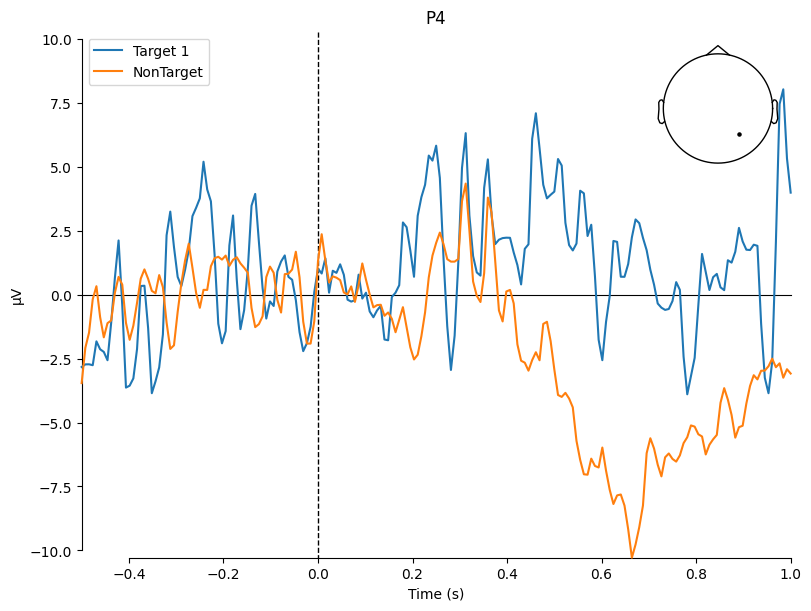

combining channels using "mean"
combining channels using "mean"


C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_8096\3808634342.py:21: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(


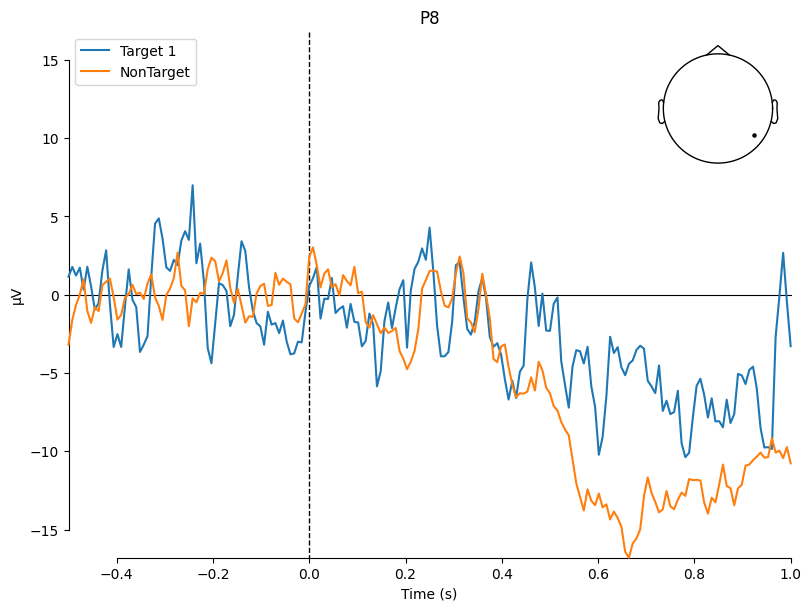

combining channels using "mean"
combining channels using "mean"


C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_8096\3808634342.py:31: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(


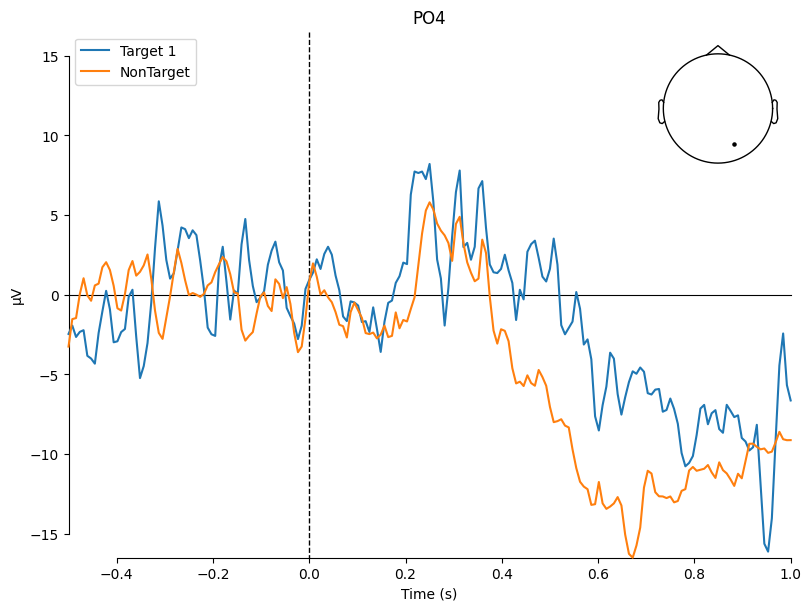

In [33]:
mne.viz.plot_compare_evokeds(
    {
        'Target 1': evoked_target,
        # 'Target 2': evoked_subtarget,
        'NonTarget': evoked_nontarget
    },
    picks='P3',
    combine='mean'
)
plt.show()
mne.viz.plot_compare_evokeds(
    {
        'Target 1': evoked_target,
        # 'Target 2': evoked_subtarget,
        'NonTarget': evoked_nontarget
    },
    picks='P4',
    combine='mean'
)
plt.show()
mne.viz.plot_compare_evokeds(
    {
        'Target 1': evoked_target,
        # 'Target 2': evoked_subtarget,
        'NonTarget': evoked_nontarget
    },
    picks='P8',
    combine='mean'
)

mne.viz.plot_compare_evokeds(
    {
        'Target 1': evoked_target,
        # 'Target 2': evoked_subtarget,
        'NonTarget': evoked_nontarget
    },
    picks='PO4',
    combine='mean'
)
plt.show()

In [32]:
def plot_compare_evokeds_multi(Bio_Epochs, picks_list, event_ids=['101', '102']):
    evokeds = {eid: Bio_Epochs[eid].average() for eid in event_ids}
    for pick in picks_list:
        mne.viz.plot_compare_evokeds(evokeds, picks=pick, combine='mean', title=f'Compare Evokeds at {pick}')
        plt.show()

# Example usage:
plot_compare_evokeds_multi(Bio_Epochs, picks_list=['Fz', 'Cz', 'Pz','P3','P4','O1','O2'], event_ids=['101', '102'])


NameError: name 'Bio_Epochs' is not defined

## 4.PSD plotting

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


c:\Users\Aitthikit\Desktop\bci_code\.venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
c:\Users\Aitthikit\Desktop\bci_code\.venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


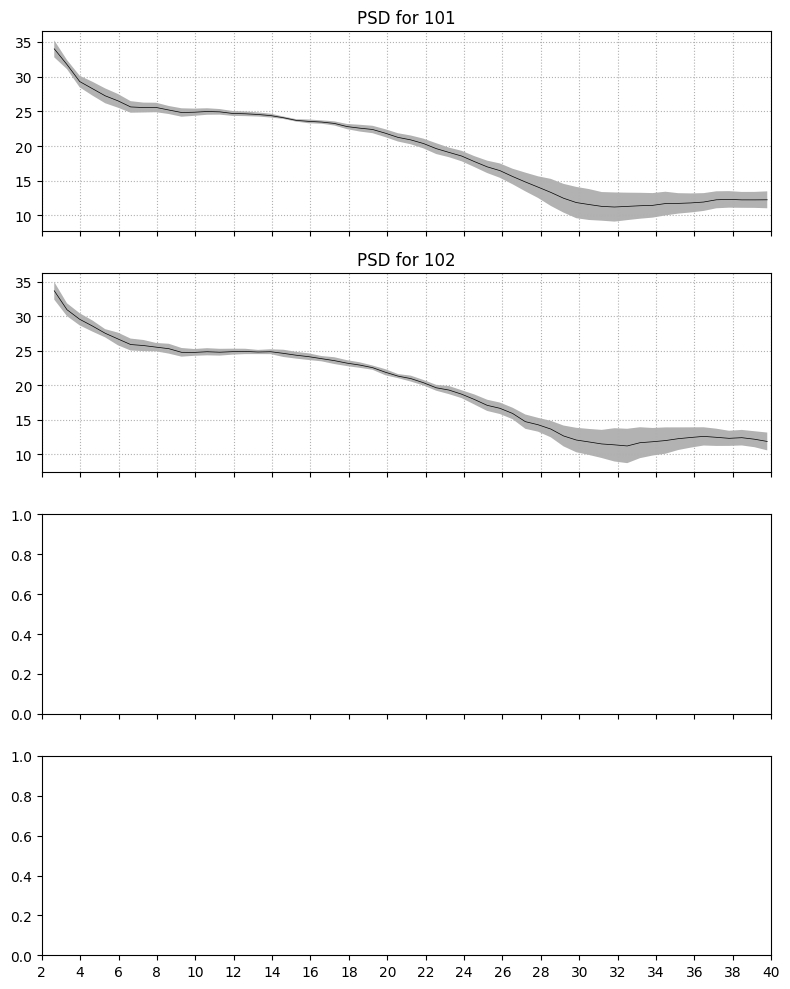

In [ ]:
# Compute the PSD for different frequency epochs
ssvep_chans = ['Fz','Cz','Pz'] 
psd_101 = Bio_Epochs['101'].pick(ssvep_chans).compute_psd(fmin=2.0, fmax=40.0)
psd_102 = Bio_Epochs['102'].pick(ssvep_chans).compute_psd(fmin=2.0, fmax=40.0)
# psd_24Hz = Bio_Epochs['24Hz'].pick(ssvep_chans).compute_psd(fmin=2.0, fmax=40.0)
# psd_30Hz = Bio_Epochs['30Hz'].pick(ssvep_chans).compute_psd(fmin=2.0, fmax=40.0)

# Store PSD objects and titles
psd_data = [(psd_101, '101'), (psd_102, '102')]

# Create subplots (1 column, 4 rows)
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 10), sharex=True)

# Plot each PSD computation in a separate subplot
for ax, (psd, title) in zip(axes, psd_data):
    psd.plot(average=True, amplitude=False, picks="data", exclude="bads", axes=ax)
    ax.set_title(f'PSD for {title}')
    ax.set_xticks(np.arange(2, 41, 2))  # Set x-axis ticks from 2 to 60 Hz
    ax.set_xticklabels(np.arange(2, 41, 2))  # Set x-axis labels

plt.tight_layout()
plt.show()